In [115]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset,Subset
from torchvision import transforms,datasets
import numpy as np
import matplotlib.pyplot as plt
import random
from tqdm import tqdm
from torch.optim import Adam
import os
from torch.utils.data import random_split
from PIL import Image
from collections import defaultdict
import random 

In [116]:
class Encoder(nn.Module):
    def __init__(self, hidden_dim=64, out_dim=64):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, hidden_dim, kernel_size=3, padding=1),  # 28x28
            nn.BatchNorm2d(hidden_dim),
            nn.ReLU(),
            nn.MaxPool2d(2),  # -> 14x14

            nn.Conv2d(hidden_dim, hidden_dim, kernel_size=3, padding=1),
            nn.BatchNorm2d(hidden_dim),
            nn.ReLU(),
            nn.MaxPool2d(2),  # -> 7x7

            nn.Conv2d(hidden_dim, hidden_dim, kernel_size=3, padding=1),
            nn.BatchNorm2d(hidden_dim),
            nn.ReLU(),
            nn.MaxPool2d(2),  # -> 3x3

            nn.Conv2d(hidden_dim, hidden_dim, kernel_size=3, padding=1),
            nn.BatchNorm2d(hidden_dim),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1))  # -> 1x1
        )
        self.fc = nn.Linear(hidden_dim, out_dim)

    def forward(self, x):
        x = self.encoder(x)          # Shape: (B, hidden_dim, 1, 1)
        x = x.view(x.size(0), -1)    # Flatten to (B, hidden_dim)
        return self.fc(x)           

In [117]:
encoder = Encoder()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
encoder.load_state_dict(torch.load("best_model.pth", map_location=device))

C:\Users\ACER\AppData\Local\Temp\ipykernel_15208\507708356.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  encoder.load_state_dict(torch.load("best_model.pth", map_locat

<All keys matched successfully>

In [118]:
class MAMLModel(nn.Module):
    def __init__(self, encoder, feature_dim=128, n_way=5):
        super().__init__()
        self.encoder = encoder

        # Two-layer MLP classifier
        self.classifier = nn.Sequential(
            nn.Linear(feature_dim, 256),  # Hidden layer with 256 units
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.3),            # Optional dropout for regularization
            nn.Linear(256, n_way)
        )

    def forward(self, x):
        features = self.encoder(x)
        logits = self.classifier(features)
        return logits

In [119]:
transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize((28, 28)),
    transforms.ToTensor(),
])

dataset_path = "./dataset"
dataset = datasets.ImageFolder(root=dataset_path, transform=transform)

class_to_images = defaultdict(list)

for image, label in dataset:
    class_to_images[label].append(image)

In [120]:

def sample_episode(class_to_images, n_way=5, k_shot=1, q_query=15):
    eligible_classes = [cls for cls, imgs in class_to_images.items() if len(imgs) >= (k_shot + q_query)]
    assert len(eligible_classes) >= n_way, f"Not enough eligible classes with >= {k_shot + q_query} samples."

    chosen_classes = random.sample(eligible_classes, n_way)

    support_images, support_labels = [], []
    query_images, query_labels = [], []

    for i, cls in enumerate(chosen_classes):
        samples = random.sample(class_to_images[cls], k_shot + q_query)
        support = samples[:k_shot]
        query = samples[k_shot:]

        support_images.extend(support)
        support_labels.extend([i] * k_shot)
        query_images.extend(query)
        query_labels.extend([i] * q_query)

    # Stack tensors
    support_x = torch.stack(support_images)
    support_y = torch.tensor(support_labels)
    query_x = torch.stack(query_images)
    query_y = torch.tensor(query_labels)

    return support_x, support_y, query_x, query_y


In [121]:
import higher

def inner_loop(encoder, support_x, support_y, n_way, inner_lr=0.01, device="cuda", inner_steps=5):
    encoder.train()
    support_x = support_x.to(device)
    support_y = support_y.to(device)

    # Create classifier fresh every episode
    with torch.no_grad():
        features = encoder(support_x)
    embedding_dim = features.shape[1]
    classifier = torch.nn.Linear(embedding_dim, n_way).to(device)
    classifier.train()

    # Wrap encoder + classifier into one sequential model
    model = torch.nn.Sequential(encoder, classifier)

    inner_opt = torch.optim.SGD(model.parameters(), lr=inner_lr)

    with higher.innerloop_ctx(model, inner_opt, copy_initial_weights=False) as (fmodel, diffopt):
        for _ in range(inner_steps):
            logits = fmodel(support_x)
            loss = F.cross_entropy(logits, support_y)
            diffopt.step(loss)
        
        # Return the adapted model (fmodel) so outer loop can use it
        return fmodel


In [122]:
import torch
import torch.nn.functional as F

def maml_outer_loop(encoder, class_to_images, n_way, k_shot, q_query, inner_lr, meta_lr, n_episodes, device="cuda"):

    encoder.to(device)
    encoder.train()

    outer_optimizer = torch.optim.Adam(encoder.parameters(), lr=meta_lr)

    for episode in range(1, n_episodes + 1):
        # Sample episode data
        support_x, support_y, query_x, query_y = sample_episode(class_to_images, n_way, k_shot, q_query)

        # Inner loop: get adapted model (encoder+classifier) after support set training
        fmodel = inner_loop(encoder, support_x, support_y, n_way, inner_lr, device)

        # Query set evaluation with adapted model
        query_x, query_y = query_x.to(device), query_y.to(device)
        query_logits = fmodel(query_x)
        query_loss = F.cross_entropy(query_logits, query_y)

        # Outer loop meta-update
        outer_optimizer.zero_grad()
        query_loss.backward()
        outer_optimizer.step()

        # Calculate meta accuracy on query set
        with torch.no_grad():
            preds = torch.argmax(query_logits, dim=1)
            acc = (preds == query_y).float().mean().item()

        if episode % 50 == 0:
            print(f"[Episode {episode}/{n_episodes}] Meta Loss: {query_loss.item():.4f} | Meta Accuracy: {acc*100:.2f}%")


In [123]:
device = "cuda" if torch.cuda.is_available() else "cpu"

# Hyperparameters
n_episodes = 1000
n_way = 5
k_shot = 5
q_query = 15
inner_lr = 5e-4
meta_lr = 1e-6

encoder.to(device)
encoder.train()

outer_optimizer = torch.optim.Adam(encoder.parameters(), lr=meta_lr)

for episode in range(1, n_episodes + 1):
    support_x, support_y, query_x, query_y = sample_episode(class_to_images, n_way, k_shot, q_query)

    fmodel = inner_loop(encoder, support_x, support_y, n_way, inner_lr, device)

    query_x, query_y = query_x.to(device), query_y.to(device)
    query_logits = fmodel(query_x)
    query_loss = F.cross_entropy(query_logits, query_y)

    outer_optimizer.zero_grad()
    query_loss.backward()
    outer_optimizer.step()

    with torch.no_grad():
        preds = torch.argmax(query_logits, dim=1)
        acc = (preds == query_y).float().mean().item()

    if episode % 50 == 0:
        print(f"[Episode {episode}/{n_episodes}] Meta Loss: {query_loss.item():.4f} | Meta Accuracy: {acc*100:.2f}%")


[Episode 50/1000] Meta Loss: 1.6615 | Meta Accuracy: 20.00%
[Episode 100/1000] Meta Loss: 1.6862 | Meta Accuracy: 20.00%
[Episode 150/1000] Meta Loss: 1.6448 | Meta Accuracy: 8.00%
[Episode 200/1000] Meta Loss: 1.5866 | Meta Accuracy: 20.00%
[Episode 250/1000] Meta Loss: 1.6675 | Meta Accuracy: 1.33%
[Episode 300/1000] Meta Loss: 1.6276 | Meta Accuracy: 18.67%
[Episode 350/1000] Meta Loss: 1.5597 | Meta Accuracy: 22.67%
[Episode 400/1000] Meta Loss: 1.5879 | Meta Accuracy: 30.67%
[Episode 450/1000] Meta Loss: 1.6504 | Meta Accuracy: 28.00%
[Episode 500/1000] Meta Loss: 1.5194 | Meta Accuracy: 25.33%
[Episode 550/1000] Meta Loss: 1.5969 | Meta Accuracy: 28.00%
[Episode 600/1000] Meta Loss: 1.5326 | Meta Accuracy: 37.33%
[Episode 650/1000] Meta Loss: 1.6033 | Meta Accuracy: 18.67%
[Episode 700/1000] Meta Loss: 1.6272 | Meta Accuracy: 20.00%
[Episode 750/1000] Meta Loss: 1.5590 | Meta Accuracy: 30.67%
[Episode 800/1000] Meta Loss: 1.6072 | Meta Accuracy: 20.00%
[Episode 850/1000] Meta Los

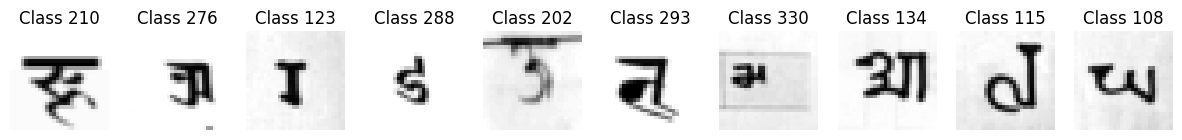

In [124]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming you already have:
# dataset = ImageFolder(root=dataset_path, transform=transform)

def imshow(img_tensor, title=None):
    # img_tensor shape: [1, 28, 28] since grayscale
    img = img_tensor.squeeze().cpu().numpy()  # remove channel dim
    plt.imshow(img, cmap='gray')
    if title:
        plt.title(title)
    plt.axis('off')

def visualize_samples(dataset, num_samples=10):
    plt.figure(figsize=(15, 3))
    indices = np.random.choice(len(dataset), num_samples, replace=False)

    for i, idx in enumerate(indices, 1):
        img, label = dataset[idx]
        plt.subplot(1, num_samples, i)
        imshow(img, title=f'Class {label}')
    plt.show()

visualize_samples(dataset, num_samples=10)
